In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install numpy==1.24.4

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505211 sha256=a6f9c7c7d8035fc1f2ed81a55c74a96fd12bd25f8e8c3f3c2e809b4eabaeb09d
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [4]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
ratings = pd.read_csv('/content/drive/My Drive/Datasets/ratings.csv')
movies  = pd.read_csv('/content/drive/My Drive/Datasets/movies.csv')

print(ratings.head())
print(movies.head())

   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [6]:
movies['title'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()
movies['metadata'] = movies['title'] + ' ' + movies['genres'].str.replace('|', ' ')

In [7]:
print("Ratings Count:")
print(ratings.count())
print("\nMovies Count:")
print(movies.count())

Ratings Count:
userId       25000095
movieId      25000095
rating       25000095
timestamp    25000095
dtype: int64

Movies Count:
movieId     62423
title       62423
genres      62423
metadata    62423
dtype: int64


In [8]:
#Collaborative Filtering with Matrix Factorization (SVD)
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
svd = SVD(n_factors=100, random_state=42)
svd.fit(trainset)

In [9]:
preds = svd.test(testset)
y_true = np.array([p.r_ui   for p in preds])
y_pred = np.array([p.est    for p in preds])

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"Error Metrics → MSE: {mse:.4f}, MAE: {mae:.4f}")

Error Metrics → MSE: 0.6042, MAE: 0.5865


In [10]:
thr     = 4.0
y_true_b = (y_true >= thr).astype(int)
y_pred_b = (y_pred >= thr).astype(int)
y_score  = y_pred  # for ROC

precision = precision_score(y_true_b, y_pred_b)
recall    = recall_score(y_true_b, y_pred_b)
f1        = f1_score(y_true_b, y_pred_b)
auc       = roc_auc_score(y_true_b, y_score)
print("Classification Metrics:")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1-Score:  {f1:.4f}")
print(f" AUC-ROC:   {auc:.4f}")

Classification Metrics:
 Precision: 0.8521
 Recall:    0.4829
 F1-Score:  0.6164
 AUC-ROC:   0.8328


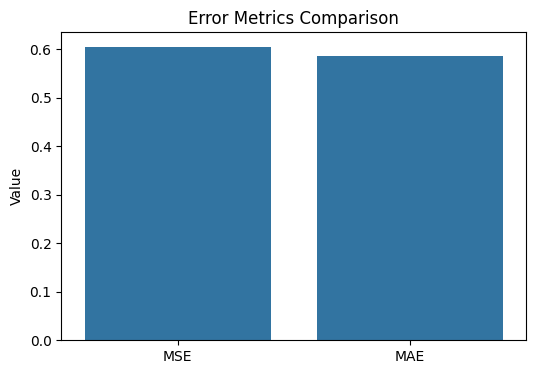

In [11]:
plt.figure(figsize=(6,4))
sns.barplot(x=['MSE','MAE'], y=[mse, mae])
plt.title('Error Metrics Comparison')
plt.ylabel('Value')
plt.show()

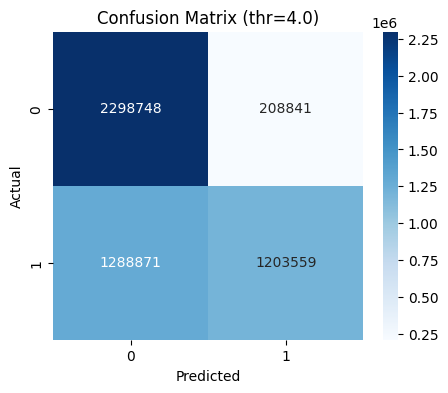

In [12]:
cm = confusion_matrix(y_true_b, y_pred_b)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (thr=4.0)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

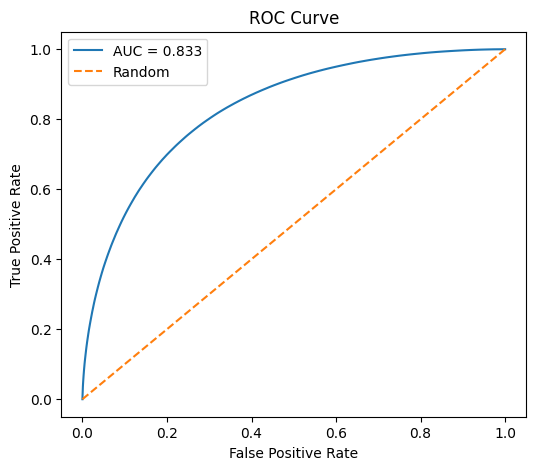

In [13]:
fpr, tpr, _ = roc_curve(y_true_b, y_score)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--', label='Random')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [14]:
#Content-Based Filtering using TF-IDF + Cosine Similarity on genres
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = tfidf.fit_transform(movies['metadata'])

In [15]:
def get_collaborative_recommendations(user_id, model, movies_df, n=10):
    all_movie_ids = movies_df['movieId'].unique()
    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].unique()
    unrated_movies = list(set(all_movie_ids) - set(rated_movies))

    testset = [[user_id, movie_id, 0] for movie_id in unrated_movies]
    predictions = model.test(testset)

    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n*2]
    return pd.DataFrame({
        'movieId': [pred.iid for pred in top_predictions],
        'predicted_rating': [pred.est for pred in top_predictions]
    })

In [16]:
def get_content_recommendations(movie_title, tfidf_matrix, movies_df, n=10):
    movie_idx = movies_df.index[movies_df['title'] == movie_title].tolist()
    if not movie_idx:
        return pd.DataFrame()
    movie_idx = movie_idx[0]

    cosine_sim = cosine_similarity(tfidf_matrix[movie_idx], tfidf_matrix).flatten()
    top_indices = cosine_sim.argsort()[-n-1:-1][::-1]

    return pd.DataFrame({
        'movieId': movies_df.iloc[top_indices]['movieId'].values,
        'similarity_score': cosine_sim[top_indices]
    })

In [17]:
def hybrid_recommendations(user_id, movie_title, svd_model, tfidf_matrix, movies_df, n=10):

    collab_recs = get_collaborative_recommendations(user_id, svd_model, movies_df, n*2)
    content_recs = get_content_recommendations(movie_title, tfidf_matrix, movies_df, n*2)

    if collab_recs.empty and content_recs.empty:
        return pd.DataFrame()

    collab_min = collab_recs['predicted_rating'].min() if not collab_recs.empty else 0
    collab_max = collab_recs['predicted_rating'].max() if not collab_recs.empty else 1
    content_min = content_recs['similarity_score'].min() if not content_recs.empty else 0
    content_max = content_recs['similarity_score'].max() if not content_recs.empty else 1


    all_movies = set(collab_recs['movieId']).union(set(content_recs['movieId']))
    hybrid_df = pd.DataFrame({'movieId': list(all_movies)})

    hybrid_df = pd.merge(hybrid_df, collab_recs, on='movieId', how='left')
    hybrid_df = pd.merge(hybrid_df, content_recs, on='movieId', how='left')


    hybrid_df['predicted_rating_norm'] = (hybrid_df['predicted_rating'] - collab_min) / (collab_max - collab_min + 1e-10)
    hybrid_df['similarity_score_norm'] = (hybrid_df['similarity_score'] - content_min) / (content_max - content_min + 1e-10)


    hybrid_df.fillna(0, inplace=True)
    hybrid_df['hybrid_score'] = 0.5 * hybrid_df['predicted_rating_norm'] + 0.5 * hybrid_df['similarity_score_norm']

    top_hybrid = hybrid_df.sort_values('hybrid_score', ascending=False).head(n)
    top_hybrid = pd.merge(top_hybrid, movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')

    return top_hybrid[['movieId', 'title', 'genres', 'hybrid_score', 'predicted_rating', 'similarity_score']]

In [18]:
recommendations = hybrid_recommendations(
    user_id=1,
    movie_title='Iron Man',
    svd_model=svd,
    tfidf_matrix=tfidf_matrix,
    movies_df=movies
)

print(recommendations)

   movieId                      title                                 genres  \
0     2997       Being John Malkovich                   Comedy|Drama|Fantasy   
1    77561                 Iron Man 2  Action|Adventure|Sci-Fi|Thriller|IMAX   
2      608                      Fargo            Comedy|Crime|Drama|Thriller   
3     1199                     Brazil                         Fantasy|Sci-Fi   
4   102125                 Iron Man 3            Action|Sci-Fi|Thriller|IMAX   
5   167296                   Iron Man                                  Drama   
6   147070                   Iron Man                                  Drama   
7     1206        Clockwork Orange, A            Crime|Drama|Sci-Fi|Thriller   
8   194228               The Iron Man                  Action|Comedy|Fantasy   
9     2360  Celebration, The (Festen)                                  Drama   

   hybrid_score  predicted_rating  similarity_score  
0      0.500000          4.729890          0.000000  
1      0.50